# Deep Neural Network API

### Features:
- Vectorized
- Customizable structure of NN:
    - number of layers
    - number of units in each layer
    - activation function of each layer
- Choice of activation functions:
    - ReLU
    - tanh
    - sigmoid
    - Leaky ReLU (WIP)
    - Softmax (WIP)
- Choice of optimization functions:
    - Gradient Descent
    - GD with momentum
    - GD with RMSProp
    - Adam

### Structure of Notebook:

1. **Network Structure definition**
2. **Forward Propagation**
3. **Cost computation**
4. **Backward Propagation**
5. **Optimization Algorithms**
    1. Gradient Descent
    2. Mini-Batch Gradient Descent
    3. Momentum
    4. RMSProp
    5. Adam
5. **Model Training function**
6. **Prediction implementation**

In [1]:
import math
import numpy as np
from nn_activation_funcs import *
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(21)

## 1. Define the structure of the Neural Network

1. Define the size of each layer in `layer_dims`
    - layer 0 = Input layer
    - layer 1 = Hidden layer
    - ...
    - layer N-1 = Hidden layer
    - layer N = Output layer
    
2. Define the activation of each layer in `layer_activations`
    - `'r'` = ReLU
    - `'t'` = tanh
    - `'s'` = sigmoid
    
**NOTE:** Length of `layer_activations` is 1 less than `layer_dims`


For example -
- layer_dims = [4, 3, 5, 3, 1]   (len = 5)
- layer_activations = ['r', 'r', 'r', 's']   (len = 4)

In [2]:
def initialize_parameters(layer_dims):
    np.random.seed(21)
    parameters = {'W': [None], 'b': [None]}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W'].append(np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01)
        parameters['b'].append(np.zeros((layer_dims[l], 1)))
        
    return parameters

## 2. Forward Propagation

$$ Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]} $$
$$ A^{[l]} = g^{[l]}(Z^{[l]}) $$

In [3]:
def forward_propagation_layer(A_prev, W, b, activation):
    # Linear step
    Z = np.dot(W, A_prev) + b
    
    # Activation step
    A = None
    if activation == 'r':
        A = relu_fwd(Z)
    elif activation == 't':
        A = tanh_fwd(Z)
    elif activation == 's':
        A = sigmoid_fwd(Z)
    
    cache = (A_prev, Z)
    
    return A, cache

In [4]:
def forward_propagation(layer_dims, layer_activations, X, parameters):
    caches = []
    A = X
    L = len(layer_dims)
    for l in range(1, L):
        # Get parameters for current layer
        A_prev = A
        W = parameters['W'][l]
        b = parameters['b'][l]
        activation = layer_activations[l]
        
        # Compute Activations and caches
        A, cache = forward_propagation_layer(A_prev, W, b, activation)
        caches.append(cache)
    return A, caches

## 3. Cost Function

We will be using cross-entropy loss function

$$ J = -\frac{1}{m} \sum_{i=1}^{m} \left( y^{(i)} log\left(a^{[L](i)}\right) + \left(1 - y^{(i)}\right) log\left(1 - a^{[L](i)}\right) \right) $$

In a vectorized implementation this becomes -

$$ J = -\frac{1}{m} \left( Y \cdot log\left(A^{[L]T}\right) + \left(1 - Y\right) \cdot log\left(1 - A^{[L]T}\right) \right) $$

where,

<table>
    <tr>
        <th> Vector </th>
        <th> Shape </th>
    </tr>
    <tr>
        <td> $Y$ </td>
        <td> $(1, m)$ </td>
    </tr>
    <tr>
        <td> $A^{[L]T}$ </td>
        <td> $(m, 1)$ </td>
    </tr>
    <tr>
        <td> $J$ </td>
        <td> $(1, 1)$ </td>
    </tr>
</table>

In [6]:
def compute_cost(Y, AL):
    m = Y.shape[1]
    
    cost = - (np.dot(Y, np.log(AL.T)) + np.dot(1 - Y, np.log(1 - AL.T))) / m
    cost = np.squeeze(cost)
    
    assert(cost.shape == ())
    
    return cost

## 4. Backward Propagation

$$ dZ^{[l]} = dA^{[l]} * g'^{[l]}(Z^{[l]}) $$
$$ dW^{[l]} = \frac{1}{m} dZ^{[l]} A^{[l-1]T} $$
$$ db^{[l]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[l](i)} $$
$$ dA^{[l-1]} = W^{[l]T} dZ^{[l]} $$

The derivative for the last layer is given by:

$$ dA^{[L]} = - \frac{Y}{A^{[L]}} + \frac{1-Y}{1-A^{[L]}} $$

In [7]:
def backward_propagation_layer(dA, Z, A_prev, A, W, b, activation):
    # Calculate dZ
    dZ = None
    if activation == 'r':
        dZ = relu_bwd(Z, A)
    elif activation == 't':
        dZ = tanh_bwd(Z, A)
    elif activation == 's':
        dZ = sigmoid_bwd(Z, A)
    
    assert(dZ.shape == Z.shape)
    
    m = A_prev.shape[1]
    
    # Calculate dW, db, dA_prev
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev, dW, db

In [8]:
def backward_propagation(layer_dims, layer_activations, A, Y, caches, parameters):
    L = len(layer_dims)
    gradients = {
        #'dA': [None for _ in range(L)],
        'dW': [None for _ in range(L)],
        'db': [None for _ in range(L)],
    }
    m = A.shape[1]
    Y = Y.reshape(A.shape)
    
    # Derivative of last layer 
    dA = - np.divide(Y, A) + np.divide(1 - Y, 1 - A)
    #gradients['dA'][L] = dA
    
    A_cur = A
    
    # For subsequent layers 
    for l in reversed(range(1, L)): # from L to 1, where A[0] is input layer
        # Get parameters for current layer
        # Note: l corresponds to previous layer's dA, so we deal with (l+1)th layer's parameters
        A_prev, Z = caches[l-1]
        W = parameters['W'][l]
        b = parameters['b'][l]
        activation = layer_activations[l]
        
        dA_prev, dW, db = backward_propagation_layer(dA, Z, A_prev, A_cur, W, b, activation)
        
        # Store gradients for use in optimization
        #gradients['dA'][l] = dA_prev
        gradients['dW'][l] = dW
        gradients['db'][l] = db
        
        # Replace current A with previous layer's A for next loop
        A_cur = A_prev
        dA = dA_prev
        
    return gradients

## 5. Optimization

### Gradient Descent

A simple optimization algorithm where we shift the weights towards lower gradients in order to find a minimum

$$ W := W - \alpha dW $$
$$ b := b - \alpha db $$

where $\alpha$ is a hyperparameter called **Learning Rate**.

In [9]:
def GD_update(layer_dims, parameters, gradients, learning_rate):
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W'][l] -= learning_rate * gradients['dW'][l]
        parameters['b'][l] -= learning_rate * gradients['db'][l]
        
    return parameters

### Mini-Batches

In simple gradient descent (aka batch gradient descent), we use the entire training set for every single parameter update. This can take a very long time for a single gradient descent step when the data set is huge. To improve the learning performance, we split up the training set into **mini-batches** and update the parameters on each mini-batch.

This has the advantage that updates are faster as only a part of the data set has to be processed.  
But when using mini-batch GD, the cost function oscillates towards the minimum instead of steadily decreasing, which can make checking the progress of the model difficult.

To implement Mini-batches in our optimization we need to implement the following:
- **Shuffle** : Creating a shuffled version of the training set will help to make each mini-batch have a similar probability distribution
- **Partition** : Partition the shuffled dataset into mini-batches of size `mini_batch_size`
- Then while calling the `forward_propagation` and `back_propagation` functions pass in the mini-batches one by one in place of `X` and `Y`

In [10]:
def generate_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # Shuffle the dataset
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    # Partition the shuffled set
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : ]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches    

### Gradient Descent with Momentum

To reduce the oscillations induced in the optimization while using gradient descent, we use **momentum** to drive the weights towards the minimum due to accumulated velocity.  
Momentum is calculated using *Exponential Weighted Average*

$$ V_{dW} = \beta V_{dW} + (1 - \beta) dW $$
$$ V_{db} = \beta V_{db} + (1 - \beta) db $$

$$ W := W - \alpha V_{dW} $$
$$ b := b - \alpha V_{db} $$

where $\alpha$ is Learning Rate, and $\beta$ is another hyperparameter. (If in doubt take $\beta = 0.9$)

In [11]:
def initialize_momentum(layer_dims):
    V = {'dW': [None], 'db': [None]}
    L = len(layer_dims)

    for l in range(1, L):
        V['dW'].append(np.zeros((layer_dims[l], layer_dims[l-1])))
        V['db'].append(np.zeros((layer_dims[l], 1)))
        
    return V

In [12]:
def GD_momentum_update(layer_dims, parameters, gradients, V, beta, learning_rate):
    L = len(layer_dims)
    
    for l in range(1, L):
        V['dW'][l] = beta * V['dW'][l] + (1 - beta) * gradients['dW'][l]
        V['db'][l] = beta * V['db'][l] + (1 - beta) * gradients['db'][l]
        
        parameters['W'][l] -= learning_rate * V['dW'][l]
        parameters['b'][l] -= learning_rate * V['db'][l]
        
    return parameters, V

### Gradient Descent with RMSProp

Another method to reduce oscillations caused by large uneven gradients in gradient descent, is to normalize the gradients with the **Root Mean Square** of the gradients. This was introduced by Geoff Hinton in his Coursera Tutorial.
It works by scaling up smaller gradients and scaling down larger gradients which can improve learning.

$$ S_{dW} = \beta S_{dW} + (1 - \beta) dW^2 $$
$$ S_{db} = \beta S_{db} + (1 - \beta) db^2 $$

$$ W := W - \alpha \frac{dW}{\sqrt{S_{dW}}} $$
$$ b := b - \alpha \frac{db}{\sqrt{S_{db}}} $$

where $\alpha$ is Learning Rate, and $\beta$ is another hyperparameter. (If in doubt take $\beta = 0.9$)

In [13]:
def initialize_RMSprop(layer_dims):
    S = {'dW': [None], 'db': [None]}
    L = len(layer_dims)
    
    for l in range(1, L):
        S['dW'].append(np.zeros((layer_dims[l], layer_dims[l-1])))
        S['db'].append(np.zeros((layer_dims[l], 1)))
        
    return S

In [14]:
def RMSprop_update(layer_dims, parameters, gradients, S, beta, learning_rate):
    L = len(layer_dims)
    
    for l in range(1, L):
        S['dW'][l] = beta * S['dW'][l] + (1 - beta) * np.square(gradients['dW'][l])
        S['db'][l] = beta * S['db'][l] + (1 - beta) * np.square(gradients['db'][l])
        
        parameters['W'][l] -= learning_rate * parameters['dW'][l] / np.sqrt(S['dW'][l])
        parameters['b'][l] -= learning_rate * parameters['db'][l] / np.sqrt(S['db'][l])
        
    return parameters, S

### Adam Optimization

Proposed by Kingma & Ba in 2015, Adam combines the ideas of momentum and RMSprop to achieve **Adaptive Momentum Estimation** (acronymed as Adam)

$$ V_{dW} = \beta_1 V_{dW} + (1 - \beta_1) dW $$
$$ V_{db} = \beta_1 V_{db} + (1 - \beta_1) db $$

$$ S_{dW} = \beta_2 S_{dW} + (1 - \beta_2) dW^2 $$
$$ S_{db} = \beta_2 S_{db} + (1 - \beta_2) db^2 $$

for iteration $t$ -
$$ V_{dW}^{corrected} = \frac{V_{dW}}{1 - \beta_1^t} , V_{db}^{corrected} = \frac{V_{db}}{1 - \beta_1^t} $$
$$ S_{dW}^{corrected} = \frac{S_{dW}}{1 - \beta_2^t} , S_{db}^{corrected} = \frac{S_{db}}{1 - \beta_2^t} $$

$$ W := W - \alpha \frac{V_{dW}^{corrected}}{\sqrt{S_{dW}^{corrected} + \epsilon}} $$
$$ b := b - \alpha \frac{V_{db}^{corrected}}{\sqrt{S_{db}^{corrected} + \epsilon}} $$

where $\alpha$ is Learning Rate, $\beta_1$ and $\beta_2$ are hyperparameters, and $\epsilon$ is a very small value to avoid division by zero.
The suggested values for the hyperparameters are: 
<table>
    <tr>
        <td> $\beta_1$ </td>
        <td> $0.9$ </td>
    </tr>
    <tr>
        <td> $\beta_2$ </td>
        <td> $0.999$ </td>
    </tr>
    <tr>
        <td> $\epsilon$ </td>
        <td> $10^{-8}$ </td>
    </tr>
</table>

In [15]:
def initialize_Adam(layer_dims):
    V = {'dW': [None], 'db': [None]}
    S = {'dW': [None], 'db': [None]}
    L = len(layer_dims)

    for l in range(1, L):
        V['dW'].append(np.zeros((layer_dims[l], layer_dims[l-1])))
        V['db'].append(np.zeros((layer_dims[l], 1)))
        
        S['dW'].append(np.zeros((layer_dims[l], layer_dims[l-1])))
        S['db'].append(np.zeros((layer_dims[l], 1)))
        
    return V, S

In [16]:
def Adam_update(layer_dims, parameters, gradients, V, S, t,  learning_rate,
                beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    L = len(layer_dims)
    
    for l in range(1, L):
        V['dW'][l] = beta1 * V['dW'][l] + (1 - beta1) * gradients['dW'][l]
        V['db'][l] = beta1 * V['db'][l] + (1 - beta1) * gradients['db'][l]
        
        S['dW'][l] = beta2 * S['dW'][l] + (1 - beta2) * np.square(gradients['dW'][l])
        S['db'][l] = beta2 * S['db'][l] + (1 - beta2) * np.square(gradients['db'][l])
        
        V_dW_corrected = V['dW'][l] / (1 - beta1**t)
        V_db_corrected = V['db'][l] / (1 - beta1**t)
        
        S_dW_corrected = S['dW'][l] / (1 - beta2**t)
        S_db_corrected = S['db'][l] / (1 - beta2**t)
        
        parameters['W'][l] -= learning_rate * V_dW_corrected / np.sqrt(S_dW_corrected + epsilon)
        parameters['b'][l] -= learning_rate * V_db_corrected / np.sqrt(S_db_corrected + epsilon)
        
    return parameters, V, S

## Model Training

To train the model we need the following inputs:

1. Training dataset - `X_train`, `Y_train`
1. Model structure definition - `layer_dims`, `layer_activations`
3. Choice of Optimization function - one of `['GD', 'GD_Mom', 'RMSProp', 'Adam']`
4. Learning Rate - `learning_rate` ($\alpha$) (default = 0.0007)
5. Size of mini batches - `mini_batch_size` (default = 64)
6. Optimizer hyperparameters -
    - `beta1` ($\beta_1$) (default = 0.9)
    - `beta2` ($\beta_2$) (default = 0.999)
    - `epsilon` ($\epsilon$) (default = 1e-8)
5. Number of epochs (1 epoch = 1 pass through complete dataset) - `num_epochs` (default = 10000)

In [52]:
def model(X, Y, layer_dims, layer_activations, optimizer, learning_rate = 0.0007, mini_batch_size = 64, 
          beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    
    assert(len(layer_dims) == len(layer_activations) + 1)
    assert(all(activation in activations for activation in layer_activations))
    
    layer_activations = [None] + layer_activations
    
    L = len(layer_dims)
    costs = []
    t = 0
    seed = 21
    m = X.shape[1]
    
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Initialize optimizer moments
    if optimizer == 'GD':
        pass
    elif optimizer == 'GD_Mom':
        V = initialize_momentum(layer_dims)
    elif optimizer == 'RMSProp':
        S = initialize_RMSprop(layer_dims)
    elif optimizer == 'Adam':
        V, S = initialize_Adam(layer_dims)
        
    # Training (optimization) loop
    for i in range(num_epochs):
        
        # Generate random mini-batches for each epoch
        seed += 1
        minibatches = generate_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        # Loop through all mini-batches
        for minibatch in minibatches:
            
            # Get the X and Y values of the minibatch
            minibatch_X, minibatch_Y = minibatch
            
            # Forward Propagation
            A, caches = forward_propagation(layer_dims, layer_activations, minibatch_X, parameters)
            
            # Calculate Cost
            cost_total += compute_cost(minibatch_Y, A)
            
            # Backward Propagation
            gradients = backward_propagation(layer_dims, layer_activations, A, minibatch_Y, caches, parameters)
            
            # Optimization update
            if optimizer == 'GD':
                parameters = GD_update(layer_dims, parameters, gradients, learning_rate)
            elif optimizer == 'GD_Mom':
                parameters, V = GD_momentum_update(layer_dims, parameters, gradients, V, beta, learning_rate)
            elif optimizer == 'RMSProp':
                parameters, S = RMSprop_update(layer_dims, parameters, gradients, S, beta, learning_rate)
            elif optimizer == 'Adam':
                t += 1 # iterations counter for Adam
                parameters, V, S = Adam_update(layer_dims, parameters, gradients, V, S, t, 
                            learning_rate, beta1, beta2, epsilon)
               
        # Average the cost over the dataset
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epochs
        if print_cost and i % 1000 == 0:
            print('Cost after epoch {}: {}'.format(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    return parameters, costs

## Prediction using trained model

To predict we execute part of forward propagation without retrieving the caches

In [62]:
def predict(layer_dims, layer_activations, X, parameters):
    A = X
    L = len(layer_dims)
    for l in range(1, L):
        # Get parameters for current layer
        A_prev = A
        W = parameters['W'][l]
        b = parameters['b'][l]
        activation = layer_activations[l-1]
        
        # Compute Activations and caches
        A, _ = forward_propagation_layer(A_prev, W, b, activation)
        
    return A

## Let's test !!

We'll test our neural network with the `2017_Financial_Data.csv` dataset included with the notebook.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [20]:
df = pd.read_csv('datasets/2017_Financial_Data.csv')
df.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2018 PRICE VAR [%],Class
0,PG,6.505800e+10,-0.0037,3.263800e+10,3.242000e+10,0.000000e+00,1.865400e+10,1.865400e+10,1.376600e+10,4.650000e+08,...,0.0505,-0.0195,-0.0529,0.0012,0.0325,0.0000,-0.0156,Consumer Defensive,4.975151,1
1,VIPS,1.102060e+10,0.3525,8.557810e+09,2.462794e+09,2.733452e+08,8.201852e+08,2.056136e+09,4.066575e+08,1.245995e+07,...,0.9219,0.4764,0.5889,1.5821,0.3805,0.2141,0.1920,Consumer Defensive,-56.320000,0
2,KR,1.153370e+11,0.0501,8.950200e+10,2.583500e+10,0.000000e+00,1.916200e+10,2.238300e+10,3.452000e+09,5.220000e+08,...,-0.0490,0.0637,0.0769,0.0071,0.1654,0.0000,0.0678,Consumer Defensive,-0.990449,0
3,RAD,2.292754e+10,0.1039,1.786283e+10,5.064707e+09,0.000000e+00,4.776995e+09,4.816124e+09,2.485830e+08,2.000650e+08,...,0.1063,-0.3365,0.0281,0.0502,-0.5295,0.0000,0.0427,Consumer Defensive,-66.666666,0
4,GIS,1.561980e+10,-0.0570,1.005200e+10,5.567800e+09,0.000000e+00,2.888800e+09,3.069200e+09,2.498600e+09,2.951000e+08,...,0.0509,0.0494,0.0046,-0.0943,0.1246,0.0000,-0.0738,Consumer Defensive,-31.280412,0


In [21]:
df.describe()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2018 PRICE VAR [%],Class
count,4.435000e+03,4236.000000,4.281000e+03,4.426000e+03,4.173000e+03,4.299000e+03,4.299000e+03,4.456000e+03,4.283000e+03,4.381000e+03,...,3877.000000,4257.000000,4149.00000,4168.000000,4067.00000,4106.000000,4110.000000,4132.000000,4960.000000,4960.000000
mean,5.085608e+09,0.953124,3.235881e+09,1.934378e+09,1.061590e+08,8.532075e+08,1.331302e+09,5.943889e+08,9.961462e+07,4.974142e+08,...,0.005444,9.660352,0.11746,1.084989,0.22719,1.457853,0.383984,0.719938,-4.461547,0.276210
std,3.148389e+10,18.956861,2.619288e+10,7.911822e+09,7.983065e+08,3.521939e+09,5.214527e+09,2.763764e+09,4.185841e+08,2.362747e+09,...,0.256422,370.977527,1.07944,32.740851,4.59341,33.852958,13.378255,31.830424,561.802215,0.447167
min,-3.004500e+07,-6.872700,-2.986888e+09,-8.138230e+08,-1.098000e+08,-1.043667e+08,-1.088000e+09,-1.868300e+10,-1.932443e+08,-1.819800e+10,...,-1.000000,-1.000000,-1.00000,-1.000000,-221.00000,-1.000000,-1.218100,-2.369900,-99.999115,0.000000
25%,5.900000e+07,0.000000,3.945000e+06,3.200000e+07,0.000000e+00,1.861650e+07,3.700850e+07,-4.376053e+06,0.000000e+00,-9.396000e+06,...,0.000000,-0.003000,0.00000,-0.008050,-0.06225,-0.059250,0.000000,-0.003925,-33.388915,0.000000
50%,4.400000e+08,0.073050,1.588160e+08,1.993761e+08,0.000000e+00,8.360500e+07,1.638000e+08,3.739450e+07,4.800000e+06,2.464000e+07,...,0.000000,0.054600,0.00000,0.066300,0.06060,0.000000,0.000000,0.067250,-13.336397,0.000000
75%,2.254111e+09,0.211625,1.170103e+09,8.823762e+08,1.400000e+07,3.711330e+08,6.229360e+08,2.604446e+08,5.300000e+07,1.976460e+08,...,0.037100,0.249200,0.09070,0.203425,0.19230,0.152600,0.001175,0.182500,2.124593,1.000000
max,1.695864e+12,825.959800,1.465577e+12,2.302870e+11,2.262000e+10,1.018530e+11,1.018530e+11,6.513565e+10,1.340100e+10,6.408900e+10,...,3.561000,18499.000000,43.55340,2014.273300,84.12770,1981.061600,837.000000,2042.000000,39219.999109,1.000000


### Clean the data

Before we can use the data with our Neural Network, we will have to preprocess it to make it suitable for our model.

##### 1. Extract features and labels

First we will extract the Input features and the Labels.
- Here, the last column `'Class'` is the **output**
    - Separate it into `Y` vector
- The first column `'Unnamed: 0'` is not useful as it only mentions the id for the stocks
    - Drop column 0
- Among the input columns, we have one _Categorical_ feature - `'Sector'`
    - Convert to one-hot encoding

In [22]:
# Separate labels into Y
Y = df['Class']

# Drop column 'Unnamed: 0" (and 'Class' as it has been separated out)
ids = df['Unnamed: 0'] # saving ids for later
X = df.drop(df.columns[[0, -1]], axis=1)

# Delete df to save memory
del(df)

In [23]:
# Convert categorical column to one-hot encoding
encoder = OneHotEncoder()
onehotdf = encoder.fit_transform(X.Sector.values.reshape(-1,1)).toarray()
onehotdf = pd.DataFrame(onehotdf, columns = encoder.get_feature_names(['Sector']))
onehotdf

,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Add one-hot encoding to the Input data and remove old column
X = pd.concat([X, onehotdf], axis=1)
X = X.drop(['Sector'], axis=1)
X

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,6.505800e+10,-0.0037,3.263800e+10,3.242000e+10,0.000000e+00,1.865400e+10,1.865400e+10,1.376600e+10,4.650000e+08,1.838900e+10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.102060e+10,0.3525,8.557810e+09,2.462794e+09,2.733452e+08,8.201852e+08,2.056136e+09,4.066575e+08,1.245995e+07,3.893281e+08,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.153370e+11,0.0501,8.950200e+10,2.583500e+10,0.000000e+00,1.916200e+10,2.238300e+10,3.452000e+09,5.220000e+08,2.932000e+09,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.292754e+10,0.1039,1.786283e+10,5.064707e+09,0.000000e+00,4.776995e+09,4.816124e+09,2.485830e+08,2.000650e+08,4.849100e+07,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.561980e+10,-0.0570,1.005200e+10,5.567800e+09,0.000000e+00,2.888800e+09,3.069200e+09,2.498600e+09,2.951000e+08,2.312700e+09,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,6.257258e+07,0.0258,5.232652e+07,1.024606e+07,0.000000e+00,9.683601e+06,9.683601e+06,5.624630e+05,0.000000e+00,5.311890e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4956,1.065240e+08,-0.0677,1.290900e+07,9.361500e+07,9.224000e+06,7.984600e+07,8.907000e+07,4.545000e+06,0.000000e+00,6.656000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4957,1.040000e+08,NaN,7.700000e+07,2.700000e+07,NaN,2.500000e+07,2.700000e+07,0.000000e+00,1.000000e+06,-2.000000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4958,1.605670e+08,-0.0246,1.334910e+08,2.707600e+07,0.000000e+00,1.926300e+07,1.926300e+07,7.813000e+06,-6.990000e+05,8.553000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### 3. Fill in missing (NaN) values

The data contains some missing values which are depicted as `NaN`. This will lead to confounding in our model and cause Arithmetic errors.

We can either drop these rows or fill them with feasible values (like the mean).

In [25]:
X[X.isnull().sum(axis=1) == 0]

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities


Thus we can see that the data set does not have any row which is completely free of `NaN`/null values

In [27]:
X.columns[X.isnull().sum(axis=0) == 0]

Index(['2018 PRICE VAR [%]', 'Sector_Basic Materials',
       'Sector_Communication Services', 'Sector_Consumer Cyclical',
       'Sector_Consumer Defensive', 'Sector_Energy',
       'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials',
       'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities'],
      dtype='object')

Also there is only one column, other than the one-hot encoded columns, which is completely free of null values

Thus we cannot get rid of the `NaN` values without losing out on important information. So we will fill the `NaN` values with mean values of the respective columns.

(NOTE: In-depth study of the dataset may lead to way of dropping columns/rows in order to reduce null values while still retaining sufficient data for training)

(NOTE: There may be better ways to fill in the null values but for the sake of simplicity we will just fill in the means here)

In [43]:
# Find columns with no values
nullCols = X.columns[X.isnull().sum(axis=0) == len(X.index)]
X = X.drop(nullCols, axis=1)

# Fill in NaN values with means
X = X.fillna(X.mean())
X.columns[X.isnull().sum(axis=0) > 0] # To show that all NaN values have been filled (output should be empty)

Index([], dtype='object')

In [29]:
(X.columns[:-11])[((X[X.columns[:-11]] == 0).astype(int).sum(axis=0) / len(X.index)) > 0.5]

Index(['R&D Expenses', 'Net Income - Non-Controlling int',
       'Net Income - Discontinued ops', 'Preferred Dividends',
       'Short-term investments', 'Deferred revenue', 'Deposit Liabilities',
       'R&D to Revenue', 'Dividends per Share Growth', 'R&D Expense Growth'],
      dtype='object')

##### 2. Normalize features

As we can see, some of the columns have very large values (in the range of 1e+10) while some have very small values (in the range of 1e-3).

Thus we will **Normalize** the data for each feature -

$$ x := \frac{x - \mu}{\sigma} $$

where $\mu$ is the Mean, and $\sigma$ is the standard deviation.

NOTE: We should not Normalize the one-hot encoded columns. There are 11 columns in the one-hot encoding. Thus we apply the Normalization for all but the last 11 columns, which can be achieved by using `X[X.columns[:-11]]`

In [30]:
# Get the mean and std for each column
X_mean = X[X.columns[:-11]].mean()
X_std = X[X.columns[:-11]].std()

# Normalize columns
X[X.columns[:-11]] = (X[X.columns[:-11]] - X_mean) / X_std
X

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,2.014476,-5.461804e-02,1.208288,4.079049,-1.449813e-01,5.429020,3.568326,5.028183,0.939382,8.057340,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.199357,-3.428521e-02,0.218706,0.070703,2.283263e-01,-0.010071,0.149310,-0.071665,-0.224069,-0.048676,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.703351,-5.154700e-02,3.545130,3.197961,-1.449813e-01,5.583953,4.336467,1.090876,1.085925,1.096397,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.599312,-4.847595e-02,0.601099,0.418846,-1.449813e-01,1.196706,0.717843,-0.132009,0.258251,-0.202169,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.353844,-5.766054e-02,0.280110,0.486161,-1.449813e-01,0.620830,0.357992,0.726921,0.502580,0.817500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,-0.168724,-5.293410e-02,-0.130829,-0.257453,-1.449813e-01,-0.257264,-0.272242,-0.226690,-0.256103,-0.223767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4956,-0.167248,-5.827133e-02,-0.132449,-0.246299,-1.323841e-01,-0.235866,-0.255889,-0.225169,-0.256103,-0.221009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4957,-0.167333,1.001316e-15,-0.129815,-0.255212,-1.587340e-15,-0.252593,-0.268675,-0.226904,-0.253532,-0.224907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4958,-0.165432,-5.581107e-02,-0.127494,-0.255202,-1.449813e-01,-0.254343,-0.270269,-0.223922,-0.257900,-0.220155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Split into Train and Test sets

We will split our data into training and testing sets so as to avoid overfitting and to retain a metric for evaluating our model on data that it hasn't seen during training.

Depending on the amount of data, the sizes of the train and test sets are decided. Since we have around 5000 data elements we can split into 80-20 ratio or set a fixed number of examples for test set (for ex. 500).

Here, we will retain 500 examples for testing and use the rest for training.

In [44]:
# First retrieve numpy arrays from the DataFrame and Series
X_data = X.values
Y_data = Y.values.reshape(Y.values.shape[0], 1)

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 500, random_state = 21)

In [46]:
X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T

### Set up the Neural Network -

Set `layer_dims` and `layer_activations`

Here, 

![NN design](nn_design.svg)

In [47]:
layer_dims = [X_train.shape[0], 125, 64, 1]
layer_activations = ['r', 'r', 's']

In [48]:
layer_dims

[232, 125, 64, 1]

In [53]:
trained_parameters, costs = model(X_train, Y_train, layer_dims, layer_activations, optimizer = 'GD', num_epochs = 500)

Cost after epoch 0: 0.010858233576765438


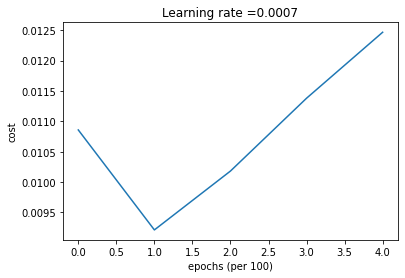

In [56]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs (per 100)')
plt.title('Learning rate =' + str(0.0007))
plt.show()

In [89]:
_outdf1_ = pd.DataFrame(Y_test.T)
_outdf2_ = pd.DataFrame(((test_predictions > 0.5) * 1).T)
pd.concat([_outdf1_, _outdf2_], axis=1)

,0,0
0,0,0
1,1,0
2,0,0
3,1,0
4,1,0
...,...,...
495,0,0
496,0,0
497,1,0
498,0,0


In [92]:
test_predictions = predict(layer_dims, layer_activations, X_test, trained_parameters)

accuracy = accuracy_score(_outdf1_, _outdf2_)

tn, fp, fn, tp = confusion_matrix(_outdf1_, _outdf2_).ravel()

print('Accuracy:', accuracy)
print('Confusion Matrix:', [[tp, fn], [tn, fp]])
print('Precision:', (tp / (tp + fp)))
print('Recall:', (tp / (tp + fn)))

Accuracy: 0.688
Confusion Matrix: [[0, 156], [344, 0]]
Precision: nan
Recall: 0.0


<ipython-input-92-560672d9ecfe>:9: RuntimeWarning: invalid value encountered in longlong_scalars
  print('Precision:', (tp / (tp + fp)))


In [36]:
parameters = initialize_parameters(layer_dims)
cost = 0
m = X_train.shape[1]

In [37]:
_activations_ = [None] + layer_activations
A, caches = forward_propagation(layer_dims, _activations_, X_train, parameters)
cost = compute_cost(Y_train, A) / m
gradients = backward_propagation(layer_dims, _activations_, A, Y_train, caches, parameters)
parameters = GD_update(layer_dims, parameters, gradients, learning_rate = 0.0007)
print(A)

[[nan nan nan ... nan nan nan]]


In [41]:
X.columns[X.isnull().sum(axis=0) == len(X.index)]

X.drop(X.columns[X.isnull().sum(axis=0) == len(X.index)], axis=1)

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,2.014476,-5.461804e-02,1.208288,4.079049,-1.449813e-01,5.429020,3.568326,5.028183,0.939382,8.057340,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.199357,-3.428521e-02,0.218706,0.070703,2.283263e-01,-0.010071,0.149310,-0.071665,-0.224069,-0.048676,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.703351,-5.154700e-02,3.545130,3.197961,-1.449813e-01,5.583953,4.336467,1.090876,1.085925,1.096397,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.599312,-4.847595e-02,0.601099,0.418846,-1.449813e-01,1.196706,0.717843,-0.132009,0.258251,-0.202169,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.353844,-5.766054e-02,0.280110,0.486161,-1.449813e-01,0.620830,0.357992,0.726921,0.502580,0.817500,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,-0.168724,-5.293410e-02,-0.130829,-0.257453,-1.449813e-01,-0.257264,-0.272242,-0.226690,-0.256103,-0.223767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4956,-0.167248,-5.827133e-02,-0.132449,-0.246299,-1.323841e-01,-0.235866,-0.255889,-0.225169,-0.256103,-0.221009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4957,-0.167333,1.001316e-15,-0.129815,-0.255212,-1.587340e-15,-0.252593,-0.268675,-0.226904,-0.253532,-0.224907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4958,-0.165432,-5.581107e-02,-0.127494,-0.255202,-1.449813e-01,-0.254343,-0.270269,-0.223922,-0.257900,-0.220155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
